# Tropics Temperature Quantile Theory from Byrne 2021
This looks at applying the theory from Byrne 2021 but to an aquaplanet. This works by saying that the change in MSE on any day is equal to the mean change in MSE.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import lcl_temp, rh_from_sphum, saturation_vapor_pressure, mixing_ratio_from_sphum, dry_profile, moist_profile, mixing_ratio_from_partial_pressure, moist_static_energy, convection_neutral_profile
from isca_tools.utils.radiation import frierson_net_toa_sw_dwn
from isca_tools.utils.constants import kappa, L_v, c_p, g, R_v, epsilon
from isca_tools.utils import area_weight_mean_lat, area_weighting
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy

2023-04-24 11:04:38,331 - isca - WARNING - Environment variable GFDL_SOC not set, but this is only required if using SocratesCodebase. Setting to None


In [115]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height']        # only keep variables required to compute relative humidity and MSE
pressure_ft = 500
# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
exp_dir = 'tau_sweep/aquaplanet/'
exp_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_exp = len(exp_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
for i in range(n_exp):
    ds_use = isca_tools.load_dataset(exp_dir + exp_names[i])[var_keep]
    ds += [ds_use.sel(pfull=[pressure_ft, np.inf], method='nearest')]      # only keep the surface values
    namelist = isca_tools.load_namelist(exp_dir + exp_names[i])  # Need this for albedo_value
    albedo += [namelist['mixed_layer_nml']['albedo_value']]
    tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
    tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]

## Get datasets
Get one dataset for summer for each $\kappa$, in a given latitude bin: `ds_all`. This combines the summer months in each hemisphere, e.g. negative latitudes will only correspond to times in January, February or March.

In [116]:
## Split datasets into land and ocean ones - load in summer dataset for ocean only
# Load in for a given latitude range
use_time_start = 360*2

# If true, will save figures to desktop
save_fig = False

# Chose whether to only consider summer days or consider all days
season = 'summer'
# season = 'all'

# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 30
# lat_max = 60
# Poles
# region = 'High Latitudes'
# lat_min = 70
# lat_max = 90

ds_all = []
with tqdm(total=n_exp, position=0, leave=True) as pbar:
    for i in range(n_exp):
        ds_use = ds[i].sel(time=slice(use_time_start, np.inf))
        ds_use = ds_use.where((np.abs(ds_use.lat) <= lat_max) & (np.abs(ds_use.lat) >= lat_min), drop=True)

        # all days not summer
        # ds_use = ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))

        if season == 'summer':
            # Only consider summer as has expected circulation
            ds_nh_summer = isca_tools.utils.annual_time_slice(ds_use, [7, 8, 9]).sel(lat=slice(lat_min, lat_max))       # NH summer is JAS
            ds_sh_summer = isca_tools.utils.annual_time_slice(ds_use, [1, 2, 3]).sel(lat=slice(-lat_max, -lat_min))     # SH summer is JFM
            # Combine hemispheres and average over longitude, time and latitude.
            # Note that April, May, June, October, November and December will not be included in this dataset
            ds_use = xr.concat([ds_sh_summer, ds_nh_summer], dim='lat')
        ds_use = ds_use.stack(lon_lat_time=("lat","lon","time"), create_index=False).chunk(dict(lon_lat_time=-1))
        ds_all += [ds_use.load()]
        if season == 'summer':
            # Get rid of nan values corresponding to the winter hemisphere - half the values are nan
            ds_all[i] = ds_all[i].sel(lon_lat_time = ds_all[i].lon_lat_time[np.invert(np.isnan(ds_all[i].temp[-1]))].to_numpy())
        pbar.update(1)

100%|██████████| 2/2 [00:10<00:00,  5.14s/it]


## MSE Percentile vs Temperature Percentile
Recreating Extended Data Figure 1 of Byrne 2021.

This shows the moist static energy percentiles (y-axis) corresponding to the average moist static energy of days exceeding the given temperature percentile.

The ocean plot shows good agreement with Byrne 2021, and this also shows that for land, in the warmer simulation, there is a decrease in $p_x$ as seen in Byrne 2021.

However, here we see an increase in $p_x$ for large $x$ over land, but in byrne 2021, we see a decrease.

In [117]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
def get_quant_ind(dataset, percentile, range_below=0, range_above=np.inf, use_var=None):
    if use_var is None:
        use_var = dataset.temp[-1]
    # Have quantile in range instead of above a given percentile
    # The default is still above a given percentile though
    quant_min = np.clip(percentile-range_below, 0, 100)
    quant_max = np.clip(percentile+range_above, 0, 100)
    # Function to find indices in dataset corresponding to surface temperature above a given quantile
    quantile_thresh_min = use_var.quantile(quant_min/100, dim='lon_lat_time', keep_attrs=True)
    quantile_thresh_max = use_var.quantile(quant_max/100, dim='lon_lat_time', keep_attrs=True)
    quant_ind = np.where(np.logical_and(use_var > quantile_thresh_min, use_var <= quantile_thresh_max))[0]
    return quant_ind

# avoid 0 quantile as it gives weird results
quant_plot = np.arange(1, 100)     # first value must be 0 so temp_quant[0] is the mean value
n_quant = len(quant_plot)


temp_mean = np.zeros(n_exp)
sphum_mean = np.zeros(n_exp)
mse_mean = np.zeros(n_exp)
mse_quant = np.zeros((n_exp, n_quant)) # surface value corresponding to the average obove a given percentile in temperature


with tqdm(total=n_exp*n_quant, position=0, leave=True) as pbar:
    for i in range(n_exp):
        temp_mean[i] = np.mean(ds_all[i].temp[-1])
        sphum_mean[i] = np.mean(ds_all[i].sphum[-1])
        mse_mean[i] = np.mean(moist_static_energy(ds_all[i].temp[-1],
                                                  ds_all[i].sphum[-1],
                                                  ds_all[i].height[-1]))
        for j, quant in enumerate(quant_plot):
            use_ind = get_quant_ind(ds_all[i], quant)
            mse_quant[i, j] = np.mean(moist_static_energy(ds_all[i].temp[-1][use_ind],
                                                          ds_all[i].sphum[-1][use_ind],
                                                          ds_all[i].height[-1][use_ind]))
            pbar.update(1)

# temp_mean = {surf: np.asarray([temp_quant[surf][i][0] for i in range(n_exp)]) for surf in surfaces}

100%|██████████| 198/198 [00:08<00:00, 24.20it/s]


In [118]:
# Get MSE percentile, p_x, corresponding to MSE averaged over all days exceeding x percentile in temperature
mse_quant_px = np.zeros((n_exp, n_quant))
with tqdm(total=n_exp*n_quant, position=0, leave=True) as pbar:
    for i in range(n_exp):
        mse_all = moist_static_energy(ds_all[i].temp[-1], ds_all[i].sphum[-1], ds_all[i].height[-1])
        for j, quant in enumerate(quant_plot):
            mse_quant_px[i, j] = percentileofscore(mse_all, mse_quant[i, j])
            pbar.update(1)

100%|██████████| 198/198 [00:00<00:00, 1146.32it/s]


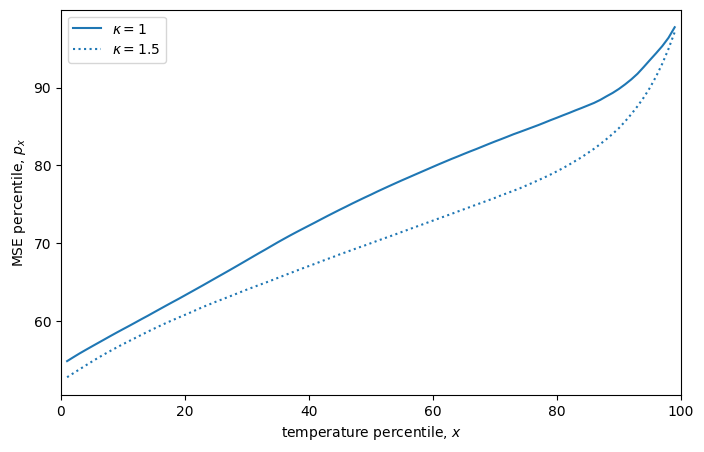

In [119]:
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
linestyles = ['-', ':']     # different for each kappa
fig, ax = plt.subplots(1,1, figsize=(8, 5), sharex=True)
for i in range(n_exp):
    ax.plot(quant_plot, mse_quant_px[i], color=default_colors[0], linestyle=linestyles[i],
            label=f'$\kappa={tau_lw[i]}$')
ax.legend()
ax.set_xlabel('temperature percentile, $x$')
ax.set_ylabel('MSE percentile, $p_x$')
ax.set_xlim(0,100);

## Ocean to Ocean Mean changes in Temperature, Specific Humidity, MSE
Attempt to reproduce Byrne 2021 Figure 3, applied to an aquaplanet.

The scaling $\lambda(p) = \frac{\delta h(p)}{\delta \overline{h}}$, is very close to 1 for all percentiles, implying that the theory may be appropriate.

In [120]:
# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant2 = np.zeros((n_exp, n_quant))
# specific humidity as function of specific humidity quantile not temp quantile
sphum_quant2 = np.zeros((n_exp, n_quant))
# mse as function of mse quantile not temp quantile
mse_quant2 = np.zeros((n_exp, n_quant))

for i in range(n_exp):
        temp_quant2[i] = ds_all[i].temp[-1].quantile(quant_plot/100, dim='lon_lat_time', keep_attrs=True)
        sphum_quant2[i] = ds_all[i].sphum[-1].quantile(quant_plot/100, dim='lon_lat_time', keep_attrs=True)
        mse = moist_static_energy(ds_all[i].temp[-1], ds_all[i].sphum[-1], ds_all[i].height[-1])
        mse_quant2[i] = mse.quantile(quant_plot/100, dim='lon_lat_time', keep_attrs=True)

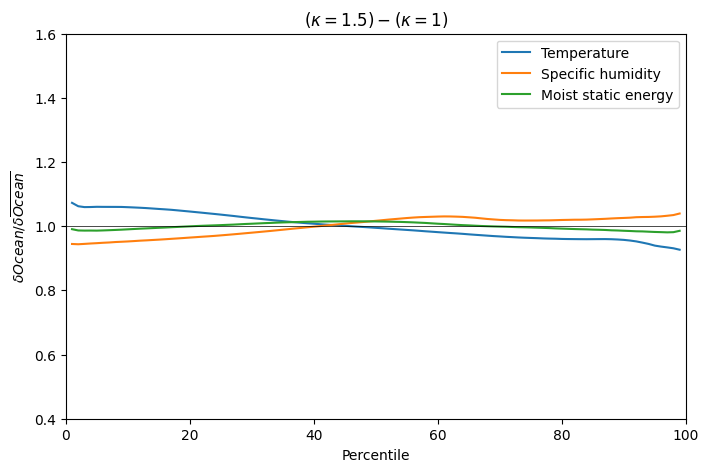

In [121]:
fig, ax = plt.subplots(1,1, figsize=(8, 5))
labels = ['Temperature', 'Specific humidity', 'Moist static energy']
# Divide by the difference in the mean not by the difference in the median because from the above plot, the percentile p_x=50 for
# MSE does not have a corresponding temperature percentile, x.
delta_var_mean = [var[1] - var[0] for var in [temp_mean, sphum_mean, mse_mean]]
for i, var in enumerate([temp_quant2, sphum_quant2, mse_quant2]):
    ax.plot(quant_plot, (var[1]-var[0])/delta_var_mean[i], label=labels[i])
ax.hlines(1,0,100, color='k', linewidth=0.5)
ax.legend()
ax.set_xlabel('Percentile')
ax.set_ylabel('$\delta Ocean/\delta \overline{Ocean}$')
ax.set_ylim(0.4,1.6)
ax.set_xlim(0, 100)
ax.set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$')
if save_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/lambda{str(tau_lw_ref).replace('.','_')}")

## Theory for $\delta T(p)$

### Form of MSE equation to start theory
From the above plot, we have $\delta h(p) = \delta \overline{h}$. Because this is an aquaplanet, higher temperatures are associated with higher moist static energies, as indicated by the $p^x$ vs $x$ plot.

Thus, we expect equation 10 in the paper: $\delta h(p) \approx c_p \delta T(p) + L_v \delta q(p)$ should hold. In the plot below, we see that this is the case to within around $2%$ except for the extremely small percentiles, $p$.

So now we can obtain an equation for $\delta T(p)$, the temperature change of the percentile $p$ of temperature. This is simpler than what is done in the paper where it cannot assume $\delta h(p) \approx c_p \delta T(p) + L_v \delta q(p)$ over land, so it instead considers the temperature change of days averaged over a given percentile, $x$, in temperature: $\delta T^x$.

Importantly, if we just consider $\delta T(p)$, we no longer have to think abut the problematic $\Delta h$ term.

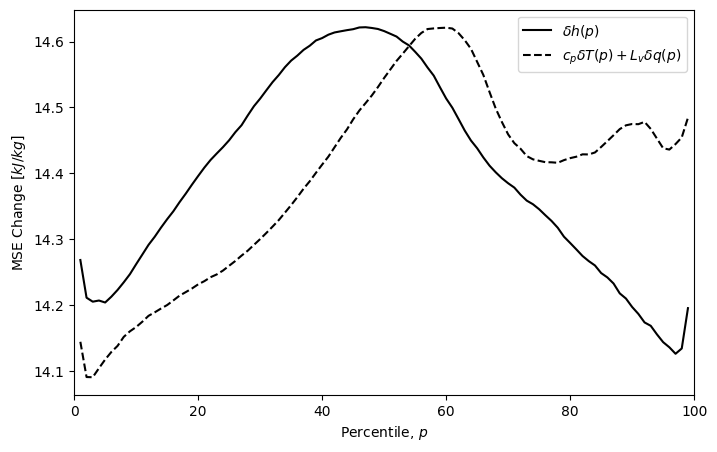

In [122]:
fig_delta_mse, ax = plt.subplots(1,1, figsize=(8, 5))
ax.plot(quant_plot, mse_quant2[1]-mse_quant2[0], label = '$\delta h(p)$', color='k')
ax.plot(quant_plot, (c_p * (temp_quant2[1]-temp_quant2[0]) + L_v * (sphum_quant2[1]-sphum_quant2[0]))/1000,
        label='$c_p \delta T(p) + L_v \delta q(p)$', color='k', linestyle='--')
ax.legend()
ax.set_xlabel('Percentile, $p$')
ax.set_ylabel('MSE Change [$kJ/kg$]')
ax.set_xlim(0,100);

### Taylor series
Our starting equation is: $\delta h(p) = \delta \overline{h}$. The left side can be approximated as $\delta h(p) \approx c_p \delta T(p) + L_v \delta q(p)$ whereas $\delta \overline{h} = c_p \delta \overline{T} + L_v \delta \overline{q}$ is exact. Thus we have:
$$c_p \delta T(p) + L_v \delta q(p) =  c_p \delta \overline{T} + L_v \delta \overline{q}$$

Next we do a taylor series of $\delta q$ where $q = q_{sat}r$ and $r$ is relative humidity. If we do this, keeping the non-linear $\delta T \delta r$ and squared temperature $\delta T^2$ terms, then we have:

$$\delta q = \alpha q\delta T + q_{sat} \delta r + \alpha q_{sat} \delta r \delta T + \frac{1}{2}\alpha q (\alpha - \frac{2}{T}) \delta T^2$$

Below, we evaluate how many of these terms we need to keep.

In [123]:
# Variables required for Delta T theory
p_surface = float(ds_all[0].pfull[-1]) * 100  # pressure where surface temperature is computed - same for all ds

def sphum_sat(temp, pressure):
    # Saturation specific humidity
    w_sat = mixing_ratio_from_partial_pressure(saturation_vapor_pressure(temp), pressure)
    q_sat = w_sat / (1+w_sat)
    return q_sat

def clausius_clapeyron_factor2(temp):
    # Rather than saying d_sphum_sat_d_temp = alpha \times sphum_sat,
    # here I explicitly compute alpha from the formula for saturation_vapor_pressure using in isca_tools
    lambda_const = 4302.645 / (temp - 29.65)**2
    return lambda_const * p_surface / epsilon * sphum_sat(temp, p_surface) / saturation_vapor_pressure(temp)

# Land constants required - all averaged over the x percentile temperature day
# i.e. there are 100 values for each of these constants
q_p_sat = sphum_sat(temp_quant2[0], p_surface)
q_mean_sat = sphum_sat(temp_mean[0], p_surface)
q_p = sphum_quant2[0]
r_p = q_p / q_p_sat
delta_r_p = sphum_quant2[1]/sphum_sat(temp_quant2[1], p_surface) - r_p
q_mean = sphum_mean[0]
r_mean = q_mean / q_mean_sat
delta_r_mean = sphum_mean[1]/sphum_sat(temp_mean[1], p_surface) - r_mean
alpha = clausius_clapeyron_factor2(temp_quant2[0])
alpha_mean = clausius_clapeyron_factor2(temp_mean[0])

delta_temp_quant = temp_quant2[1] - temp_quant2[0]
delta_temp_mean = temp_mean[1] - temp_mean[0]
delta_mse_mean = (mse_mean[1] - mse_mean[0])

In [124]:
term0 = c_p * delta_temp_quant
term1 = L_v * alpha * q_p * delta_temp_quant
term2 = L_v * q_p_sat * delta_r_p
term3 = L_v * q_p_sat * alpha * delta_r_p * delta_temp_quant
term4 = 0.5 * L_v * q_p * alpha * (alpha - 2/temp_quant2[0])*delta_temp_quant**2
mse_taylor_terms = np.asarray([term0, term1, term2, term3, term4])
term0 = c_p * delta_temp_mean
term1 = L_v * alpha_mean * q_mean * delta_temp_mean
term2 = L_v * q_mean_sat * delta_r_mean
term3 = L_v * q_mean_sat * alpha_mean * delta_r_mean * delta_temp_mean
term4 = 0.5 * L_v * q_mean * alpha_mean * (alpha_mean - 2/temp_mean[0])*delta_temp_mean**2
mse_mean_taylor_terms = np.asarray([term0, term1, term2, term3, term4])

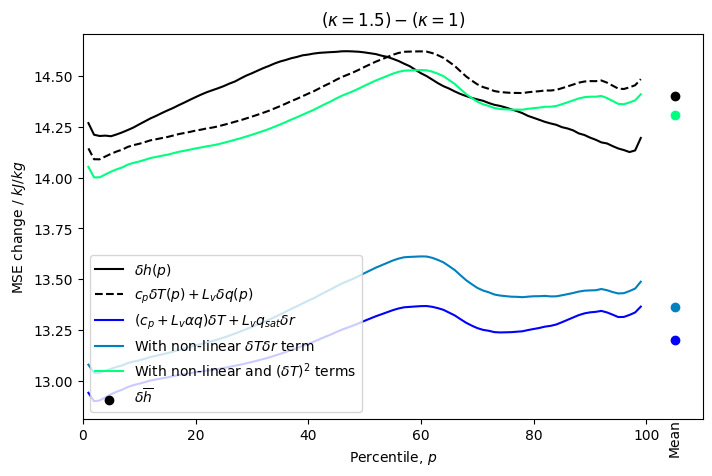

In [125]:
warm_colors = plt.cm.winter(np.linspace(0,1,3))
fig, ax = plt.subplots(1,1, figsize=(8, 5))
ax.plot(quant_plot, mse_quant2[1]-mse_quant2[0], label = '$\delta h(p)$', color='k')
ax.plot(quant_plot, (c_p * (temp_quant2[1]-temp_quant2[0]) + L_v * (sphum_quant2[1]-sphum_quant2[0]))/1000,
        label='$c_p \delta T(p) + L_v \delta q(p)$', color='k', linestyle='--')
ax.plot(quant_plot, np.sum(mse_taylor_terms[:3], axis=0)/1000, color=warm_colors[0],
        label='$(c_p+L_v\\alpha q) \delta T + L_v q_{sat} \delta r$')
ax.plot(quant_plot, np.sum(mse_taylor_terms[:4], axis=0)/1000, color=warm_colors[1],
        label='With non-linear $\delta T \delta r$ term')
ax.plot(quant_plot, np.sum(mse_taylor_terms, axis=0)/1000, color=warm_colors[2],
        label='With non-linear and $(\delta T)^2$ terms')
mean_plot_val = 105
ax.scatter(mean_plot_val, delta_mse_mean, color='k', label='$\delta \overline{h}$')
ax.scatter(mean_plot_val, np.sum(mse_mean_taylor_terms[:3])/1000, color=warm_colors[0])
ax.scatter(mean_plot_val, np.sum(mse_mean_taylor_terms[:4])/1000, color=warm_colors[1])
ax.scatter(mean_plot_val, np.sum(mse_mean_taylor_terms[:5])/1000, color=warm_colors[2])
ax.legend(loc='lower left')
ax.set_xlabel('Percentile, $p$')
ax.set_ylabel('MSE change / $kJ/kg$')
ax.set_xlim(0,mean_plot_val+5)
ax.text(mean_plot_val, 0, 'Mean', color='k', transform=ax.get_xaxis_transform(),
            ha='center', va='top', rotation='vertical')
ax.set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$')

if save_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/mse_taylor{str(tau_lw_ref).replace('.','_')}")

### $\delta T(p)$ Plot
From the above plot, keeping more terms in the taylor series doesn't seem to make the equality between $\delta h(p)$ (lines) and $\delta \overline{h}$ (dots) any better. This would indicate that we should only keep the linear terms as it makes for the most simple theory.

I keep all three versions below anyway (in the equations below, quantities with an overline refer to the mean value and quantitites without one refer to the percentile $p$ value.
#### Linear
$$\delta T = \frac{1}{c_p + L_v \alpha q}\bigg((c_p + L_v \bar{\alpha} \bar{q})\delta \bar{T} + L_v \overline{q_{sat}}\delta \bar{r} - L_v q_{sat}\delta r\bigg)$$

#### Non-linear
$$\delta T =
\frac{1}{c_p + L_v \alpha (q + q_{sat}\delta r)}\bigg((c_p + L_v \bar{\alpha} \bar{q})\delta \bar{T} + L_v \overline{q_{sat}}\delta \bar{r} - L_v q_{sat}\delta r + L_v \bar{\alpha} \overline{q_{sat}} \delta \bar{r} \delta \bar{T}\bigg) \\ =
\frac{1}{1+\epsilon \delta r}\frac{1}{c_p + L_v \alpha q}\bigg((c_p + L_v \bar{\alpha} \bar{q})\delta \bar{T} + L_v \overline{q_{sat}}\delta \bar{r} - L_v q_{sat}\delta r + L_v \bar{\alpha} \overline{q_{sat}} \delta \bar{r} \delta \bar{T}\bigg)$$
Where $\epsilon = \frac{L_v \alpha q_{sat}}{c_p + L_v \alpha q}$

#### Squared
The squared solution is found by solving the full quadratic equation for $\delta T$, containing squared and non-linear terms.

In [126]:
lambda_p = (mse_quant2[1] - mse_quant2[0]) / delta_mse_mean
coef_a = 0.5 * L_v * alpha * q_p * (alpha - 2/temp_quant2[0])
coef_b = c_p + L_v * alpha * (q_p + q_p_sat * delta_r_p)
coef_c = L_v * q_p_sat * delta_r_p - lambda_p * (
         0.5 * L_v * alpha_mean * q_mean * (alpha_mean - 2/temp_mean[0]) * delta_temp_mean**2 +
         (c_p + L_v * alpha_mean * (q_mean + q_mean_sat * delta_r_mean)) * delta_temp_mean +
         L_v * q_mean_sat * delta_r_mean)
temp_diff_theory_squared_lambda = np.asarray([np.roots([coef_a[i], coef_b[i], coef_c[i]])[1] for i in range(n_quant)])
coef_c = L_v * q_p_sat * delta_r_p - (
         0.5 * L_v * alpha_mean * q_mean * (alpha_mean - 2/temp_mean[0]) * delta_temp_mean**2 +
         (c_p + L_v * alpha_mean * (q_mean + q_mean_sat * delta_r_mean)) * delta_temp_mean +
         L_v * q_mean_sat * delta_r_mean)
temp_diff_theory_squared = np.asarray([np.roots([coef_a[i], coef_b[i], coef_c[i]])[1] for i in range(n_quant)])

coef_c = coef_c + 0.5 * L_v * alpha_mean * q_mean * (alpha_mean - 2/temp_mean[0]) * delta_temp_mean**2
temp_diff_theory_nonlinear = -coef_c/coef_b

coef_b = coef_b - L_v * alpha * q_p_sat * delta_r_p
coef_c = coef_c + L_v * alpha_mean * q_mean_sat * delta_r_mean
temp_diff_theory_linear = -coef_c/coef_b

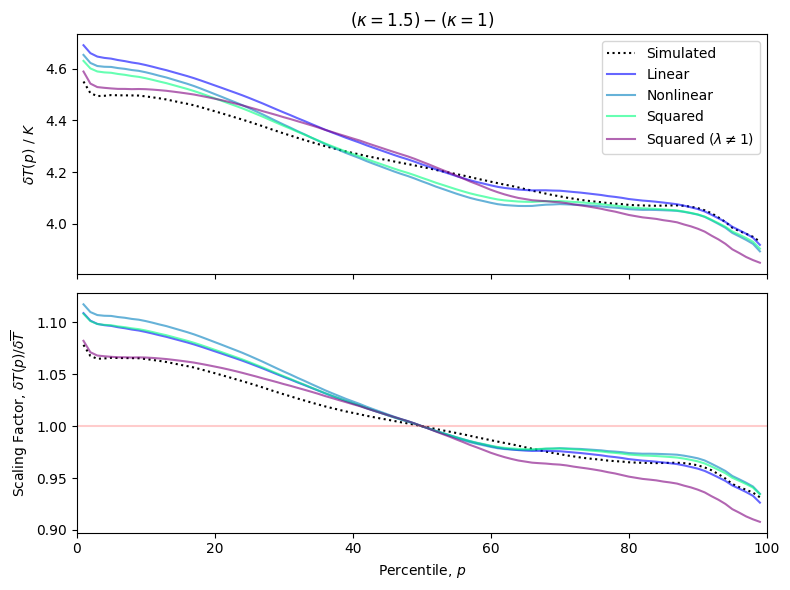

In [127]:
# take median as average rather than mean because theory does not predict change to mean temperature
av_quant_ind = np.where(quant_plot==50)[0]
fig, ax = plt.subplots(2,1, figsize=(8, 6), sharex=True)
ax[0].plot(quant_plot, temp_quant2[1]-temp_quant2[0], label = 'Simulated', color='k', linestyle=':')
ax[0].plot(quant_plot, temp_diff_theory_linear, color=warm_colors[0], label='Linear', alpha=0.6)
ax[0].plot(quant_plot, temp_diff_theory_nonlinear, color=warm_colors[1],
           label='Nonlinear', alpha=0.6)
ax[0].plot(quant_plot, temp_diff_theory_squared, color=warm_colors[2],
           label='Squared', alpha=0.6)
ax[0].plot(quant_plot, temp_diff_theory_squared_lambda, color='purple',
           label='Squared ($\lambda \\neq 1$)', alpha=0.6)
ax[1].plot(quant_plot, (temp_quant2[1]-temp_quant2[0])/(temp_quant2[1]-temp_quant2[0])[av_quant_ind],
           label = 'Simulated', color='k', linestyle=':')
ax[1].plot(quant_plot, temp_diff_theory_linear/temp_diff_theory_linear[av_quant_ind],
           color=warm_colors[0], label='Linear', alpha=0.6)
ax[1].plot(quant_plot, temp_diff_theory_nonlinear/temp_diff_theory_nonlinear[av_quant_ind],
           color=warm_colors[1], label='Nonlinear', alpha=0.6)
ax[1].plot(quant_plot, temp_diff_theory_squared/temp_diff_theory_squared[av_quant_ind],
           color=warm_colors[2], label='Squared', alpha=0.6)
ax[1].plot(quant_plot, temp_diff_theory_squared_lambda/temp_diff_theory_squared_lambda[av_quant_ind], color='purple',
           label='Squared ($\lambda \\neq 1$)', alpha=0.6)
ax[1].hlines(1, -10, 100, color='r', alpha=0.2)
ax[0].legend()
ax[1].set_xlabel('Percentile, $p$')
ax[0].set_ylabel('$\delta T(p)$ / $K$')
ax[1].set_ylabel('Scaling Factor, $\delta T(p) / \delta \overline{T}$')
ax[0].set_xlim(0,100)
ax[0].set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$')
plt.tight_layout()

if save_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp_taylor{str(tau_lw_ref).replace('.','_')}")

## Breakdown of contributions to the theoretical temperature change
The idea here is to breakdown the temperature contributions to see what is the dominant term in the theory, explaining why the temperature change decreases as the percentile increases. I assume $\epsilon = 0$ for simplicity, but also plot the non-linear terms. I neglect the squared terms.

It is basically replicating Figure 4 of Byrne 2021.

Rather than plotting the $\delta r$ and $\delta \overline{r}$ terms separately, I combine them i.e. the $\delta \overline{r} - \delta r$ line shows $\frac{L_v \overline{q_{sat}}\delta \bar{r} - L_v q_{sat}\delta r}{c_p + L_v \alpha q}$.
I also simplify this by doing a Taylor series expansion in $q_{sat}(T(p))$ around $\bar{T}$ to give $\frac{L_v\overline{q_{sat}}\delta (\bar{r} - r)}{c_p + L_v \alpha q}$. This is shown by the blue dotted line, and is basically the same but makes for easier interpretation. This is what is shown as $\gamma^{\Delta r}$ in the $\gamma$ plots.

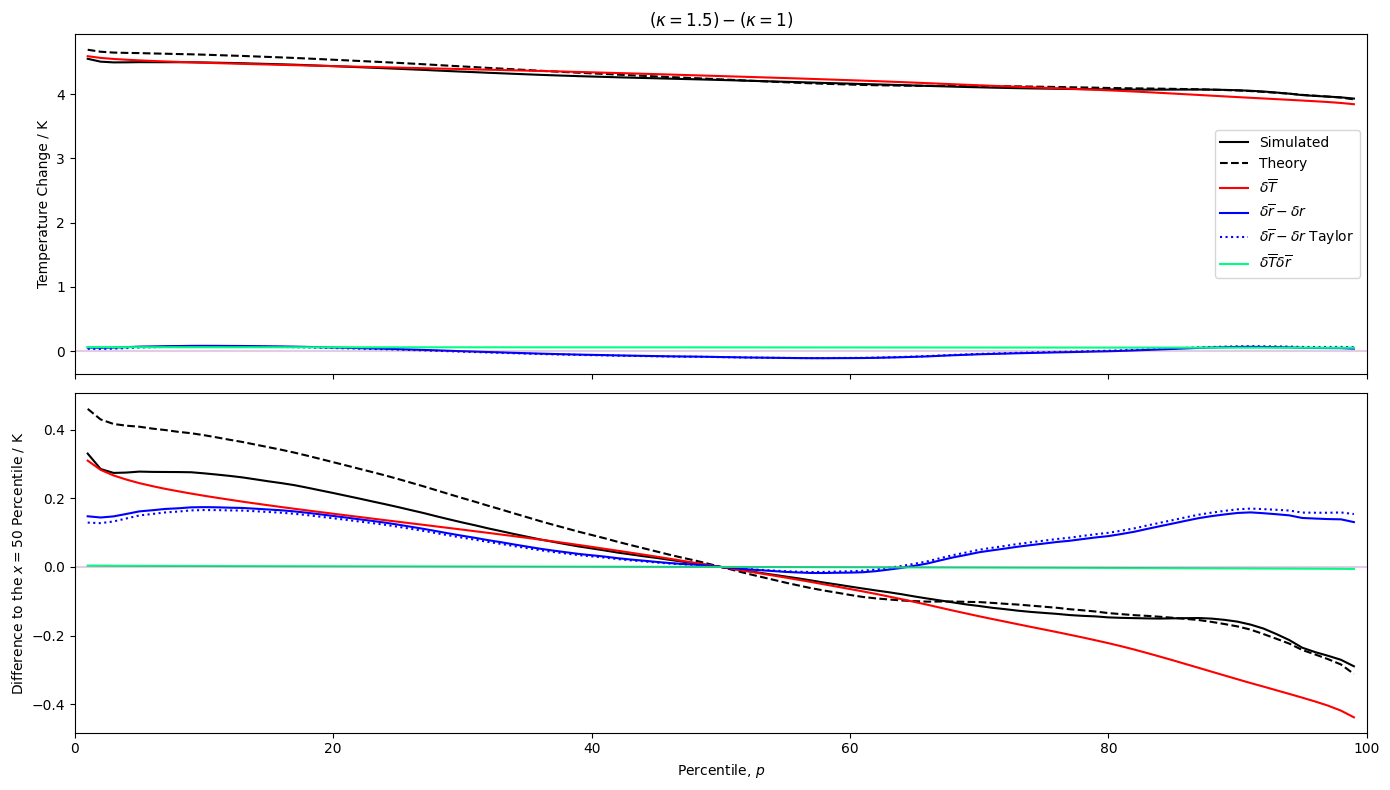

In [128]:
denom = c_p + L_v * alpha * q_p
gamma_t = (c_p + L_v * alpha_mean * q_mean) / denom
gamma_r_mean = L_v * q_mean_sat / denom
gamma_r_p = -L_v * q_p_sat / denom
gamma_nonlinear = L_v * alpha_mean * q_mean_sat / denom
gamma_rdiff = L_v/denom * q_mean_sat

fig, ax = plt.subplots(2,1, figsize=(14, 8), sharex=True)
ax[0].plot(quant_plot, temp_quant2[1]-temp_quant2[0], label = 'Simulated', color='k')
ax[0].plot(quant_plot, temp_diff_theory_linear, label='Theory', color='k', linestyle='--')
ax[0].plot(quant_plot, gamma_t * delta_temp_mean, label='$\delta \\overline{T}$', color='r')
ax[0].plot(quant_plot, gamma_r_mean * delta_r_mean + gamma_r_p * delta_r_p, color=warm_colors[0],
           label='$\delta \\overline{r} - \delta r$')
ax[0].plot(quant_plot, gamma_rdiff * (delta_r_mean - delta_r_p), color=warm_colors[0],
           label='$\delta \\overline{r} - \delta r$ Taylor', linestyle=':')
ax[0].plot(quant_plot, gamma_nonlinear * delta_r_mean * delta_temp_mean, color=warm_colors[2],
           label='$\delta \\overline{T} \delta \\overline{r}$')
ax[0].legend()
var_plot = [temp_quant2[1]-temp_quant2[0], temp_diff_theory_linear, gamma_t * delta_temp_mean,
            gamma_r_mean * delta_r_mean + gamma_r_p * delta_r_p, gamma_rdiff * (delta_r_mean - delta_r_p),
            gamma_nonlinear * delta_r_mean * delta_temp_mean]
ax[1].plot(quant_plot, var_plot[0]-var_plot[0][av_quant_ind], label = 'Simulated', color='k')
ax[1].plot(quant_plot, var_plot[1]-var_plot[1][av_quant_ind], label='Theory', color='k', linestyle='--')
ax[1].plot(quant_plot, var_plot[2]-var_plot[2][av_quant_ind], label='$\delta \\overline{T}$', color='r')
ax[1].plot(quant_plot, var_plot[3]-var_plot[3][av_quant_ind], color=warm_colors[0], label='$\delta \\overline{r}$')
ax[1].plot(quant_plot, var_plot[4]-var_plot[4][av_quant_ind], color=warm_colors[0], linestyle=':')
ax[1].plot(quant_plot, var_plot[5]-var_plot[5][av_quant_ind], color=warm_colors[2],
           label='$\delta \\overline{T} \delta \\overline{r}$')
ax[0].hlines(0, -10, 100, color='purple', alpha=0.2)
ax[1].hlines(0, -10, 100, color='purple', alpha=0.2)
ax[0].set_ylabel('Temperature Change / K')
ax[1].set_ylabel(f'Difference to the $x={int(quant_plot[av_quant_ind])}$ Percentile / K')
ax[0].set_xlim(0,100)
ax[0].set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$')
ax[-1].set_xlabel('Percentile, $p$')
plt.tight_layout()

if save_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/gamma{str(tau_lw_ref).replace('.','_')}")

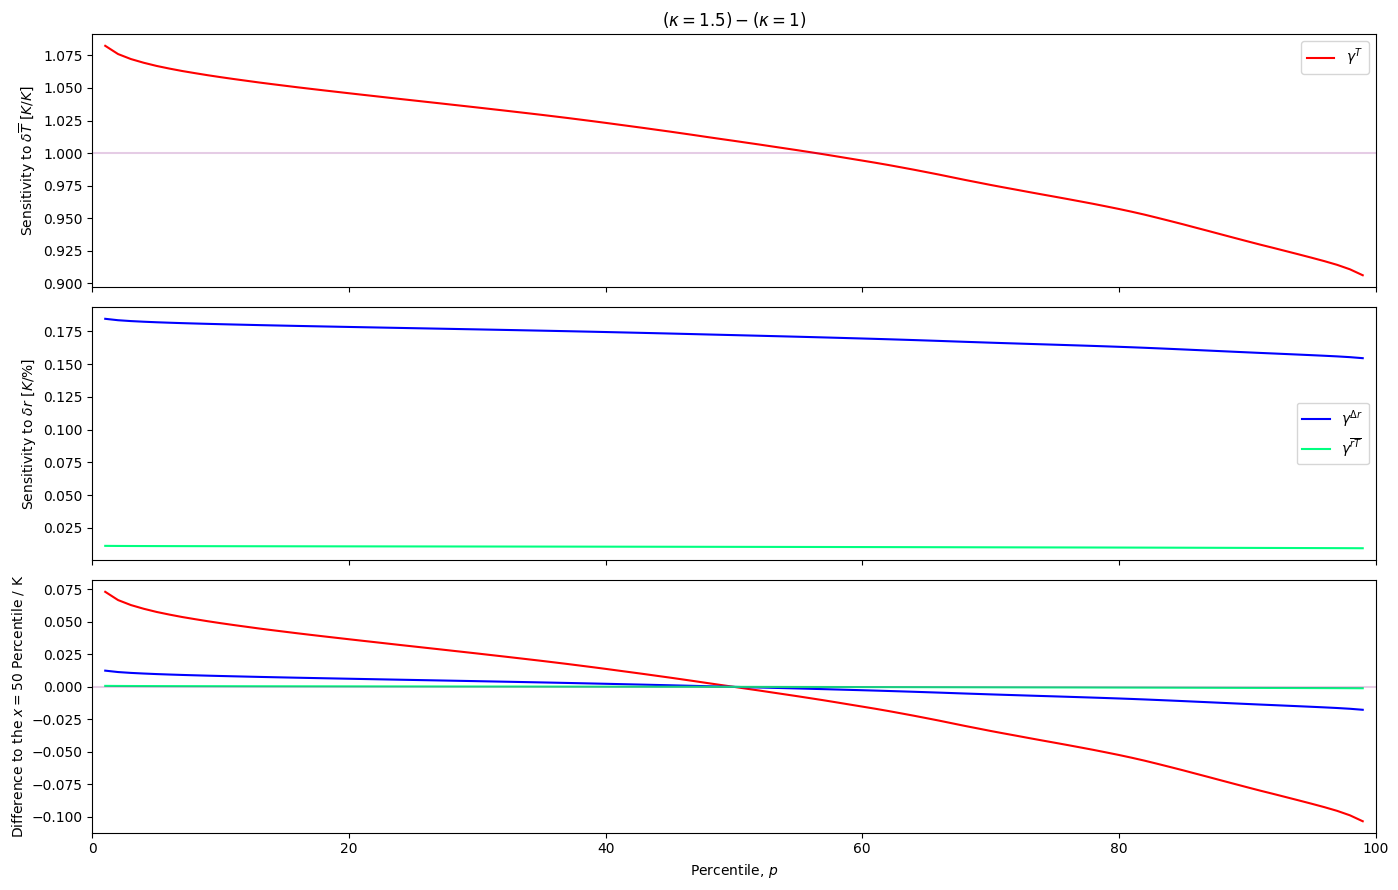

In [129]:
fig, ax = plt.subplots(3,1, figsize=(14, 9), sharex=True)
ax[0].plot(quant_plot, gamma_t, color='r', label='$\gamma^T$')
ax[1].plot(quant_plot, gamma_rdiff/100, color=warm_colors[0], label='$\gamma^{\Delta r}$')
# ax[1].plot(quant_plot, gamma_r_p/100, color=warm_colors[1], label='$\gamma^{r}$')
ax[1].plot(quant_plot, gamma_nonlinear/100, color=warm_colors[2], label='$\gamma^{\overline{rT}}$')
ax[2].plot(quant_plot, gamma_t - gamma_t[av_quant_ind], color='r')
ax[2].plot(quant_plot, (gamma_rdiff - gamma_rdiff[av_quant_ind])/100, color=warm_colors[0])
ax[2].plot(quant_plot, (gamma_nonlinear - gamma_nonlinear[av_quant_ind])/100, color=warm_colors[2])
ax[2].hlines(0, -10, 100, color='purple', alpha=0.2)
ax[0].hlines(1, -10, 100, color='purple', alpha=0.2)
ax[0].set_ylabel('Sensitivity to $\delta \overline{T}$ [$K/K$]')
ax[1].set_ylabel('Sensitivity to $\delta r$ [$K/$%]')
ax[2].set_ylabel(f'Difference to the $x={int(quant_plot[av_quant_ind])}$ Percentile / K')
ax[0].set_xlim(0,100)
ax[0].set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$')
ax[-1].set_xlabel('Percentile, $p$')
ax[0].legend()
ax[1].legend()
plt.tight_layout();

### Temperature Contribution, $\gamma^T$
$\gamma^T = \frac{c_p + L_v \bar{\alpha} \bar{q}}{c_p + L_v \alpha q}$ so when $\alpha(p) q(p) < \bar{\alpha}\bar{q}$, $\gamma^{T}(p) > 1$ and the percentile $p$ day warms more than the average. From the plot below, we see that the $\alpha q$ and the $q$ plots are essentially the same. Hence, for a percentile $p$ day to have a temperature contribution that makes it warm more than the average, it must have lower specific humidity than the average.

Clearly, in this simulation, as percentile increases, specific humidity increases and thus $\delta T(p)$ decreases.

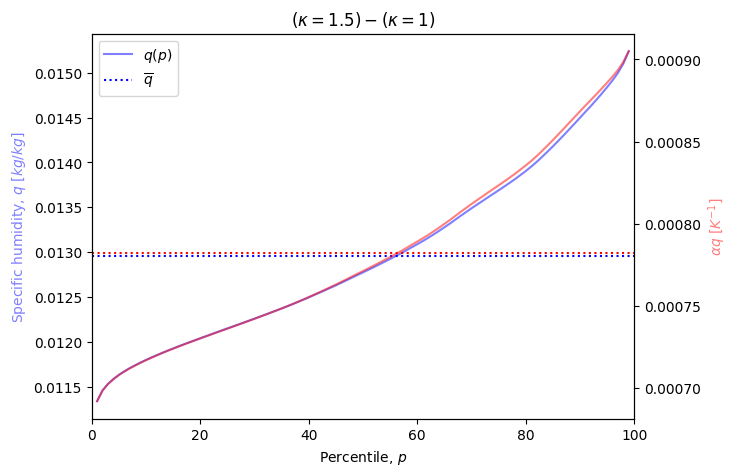

In [130]:
fig, ax = plt.subplots(1,1, figsize=(7, 5))
ax.plot(quant_plot, q_p, color='b', alpha=0.5, label='$q(p)$')
ax.hlines(q_mean, 0, 100, color='b', linestyle=':', label='$\overline{q}$')
ax.legend()
ax2 = ax.twinx()
ax2.plot(quant_plot, q_p * alpha, color='r', alpha=0.5)
ax2.hlines(q_mean * alpha_mean, 0, 100, color='r', linestyle=':')
ax.set_xlabel('Percentile, $p$')
ax.set_ylabel('Specific humidity, $q$ [$kg/kg$]', color='b', alpha=0.5)
ax2.set_ylabel('$\\alpha q$ [$K^{-1}$]', color='r', alpha=0.5)
ax.set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$')
ax.set_xlim(0,100);

### Relative Humidity Contribution
The combined relative humidity contribution is given by $\gamma^{\overline{r}}\delta \overline{r} + \gamma^{r}\delta r(p) =
\frac{L_v(\overline{q_{sat}} \delta \bar{r} - q_{sat} \delta r)}{c_p + L_v \alpha q}$.

If we do a taylor series expansion of the $q_{sat}$ term in the numerator, we get $\frac{L_v\overline{q_{sat}}\delta (\bar{r} - r) - L_v \bar{\alpha}\overline{q_{sat}}(T(p)-\bar{T})\delta r}{c_p + L_v \alpha q}$.

The plot below shows that we can approximate this as $\frac{L_v\overline{q_{sat}}\delta (\bar{r} - r)}{c_p + L_v \alpha q}$.

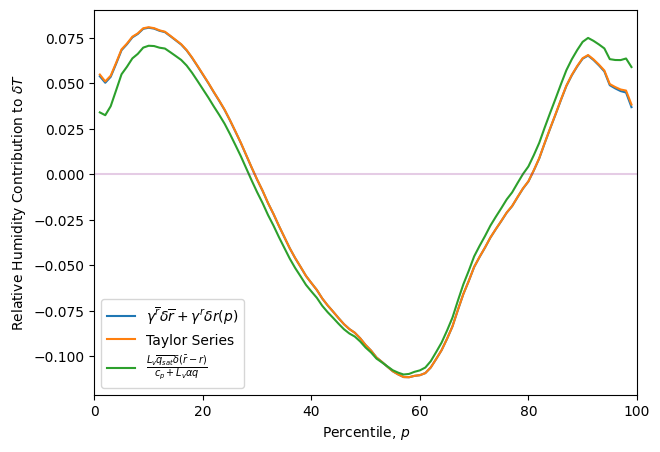

In [131]:
fig, ax = plt.subplots(1,1, figsize=(7, 5))
ax.plot(quant_plot, gamma_r_mean * delta_r_mean + gamma_r_p * delta_r_p, label='$\gamma^{\overline{r}}\delta \overline{r} + \gamma^{r}\delta r(p)$')
ax.plot(quant_plot, L_v/denom * (q_mean_sat * (delta_r_mean - delta_r_p) -
                                  alpha_mean * q_mean_sat * (temp_quant2[0] - temp_mean[0]) * delta_r_p), label='Taylor Series')
ax.plot(quant_plot, gamma_rdiff * (delta_r_mean - delta_r_p), label='$\\frac{L_v\overline{q_{sat}}\delta (\\bar{r} - r)}{c_p + L_v \\alpha q}$')
ax.hlines(0, -10, 100, color='purple', alpha=0.2)
ax.legend()
ax.set_xlabel('Percentile, $p$')
ax.set_ylabel('Relative Humidity Contribution to $\delta T$')
ax.set_xlim(0,100);

This means that whenever the change in relative humidity on a percentile $p$ day is less than on the mean day, $\delta (\bar{r} - r) > 0$, we get a positive contribution to $\delta T$. As shown below, for this simulation $\delta (\bar{r} - r) > 0$ for small percentiles ($p < 30$) and large percentiles ($p > 80$), thus the relative humidity changes lead to amplified warming of the extreme cold and warm days relative to the mean.

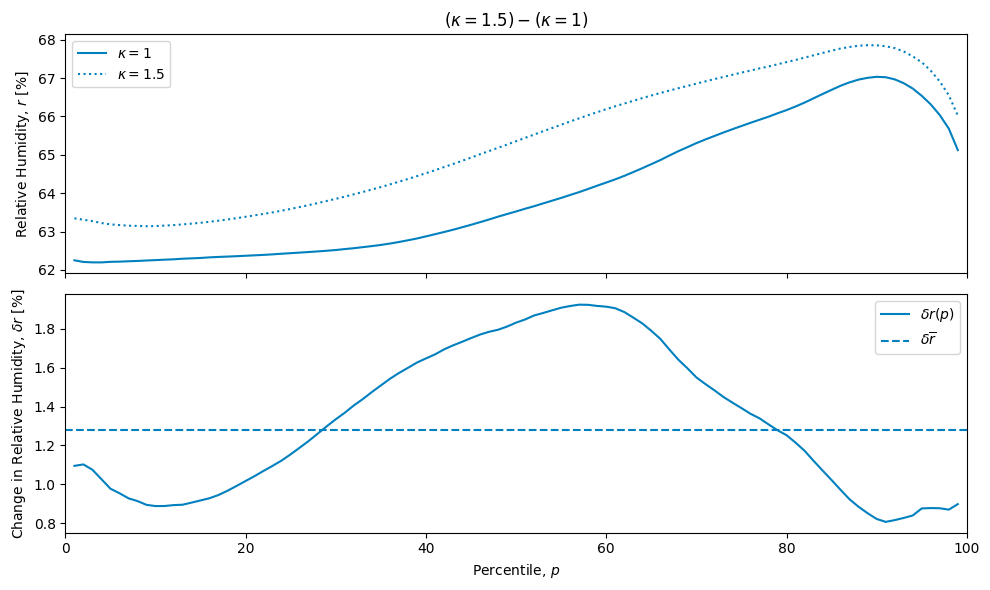

In [132]:
fig, ax = plt.subplots(2,1, figsize=(10, 6), sharex=True)
ax[0].plot(quant_plot, r_p * 100, color=warm_colors[1], label=f'$\kappa={tau_lw[0]}$')
ax[0].plot(quant_plot, (r_p+delta_r_p) * 100, color=warm_colors[1], linestyle=':', label=f'$\kappa={tau_lw[1]}$')
ax[1].plot(quant_plot, delta_r_p * 100, color=warm_colors[1], label='$\delta r(p)$')
ax[1].hlines(delta_r_mean * 100, 0, 100, color=warm_colors[1], linestyles='--', label='$\delta \overline{r}$')
ax[0].set_xlim(0,100)
ax[-1].set_xlabel('Percentile, $p$')
ax[0].set_ylabel('Relative Humidity, $r$ [%]')
ax[1].set_ylabel('Change in Relative Humidity, $\delta r$ [%]')
ax[0].legend()
ax[1].legend()
ax[0].set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$')
plt.tight_layout()

if save_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/rh{str(tau_lw_ref).replace('.','_')}")

## Theories with and without relative humidity changes
Below I replicate Figure 2 of Byrne 2021 by plotting the linear theory with and without the relative humidity change contribution. I use the linear equation with the Taylor series expansion to combine the $\delta \overline{r}$ and $\delta {r}$ terms as it is the simplest and this last taylor series made very little difference as is shown in the above plots.
$$\delta T = \frac{c_p + L_v \bar{\alpha} \bar{q}}{c_p + L_v \alpha q} \delta \bar{T} + \frac{L_v \overline{q_{sat}}}{{c_p + L_v \alpha q}}\delta (\bar{r} -  r)$$
The term labelled *Constant RH Change* is this theory but without the last term i.e. we assume change in relative humidity is always equal to the mean change.

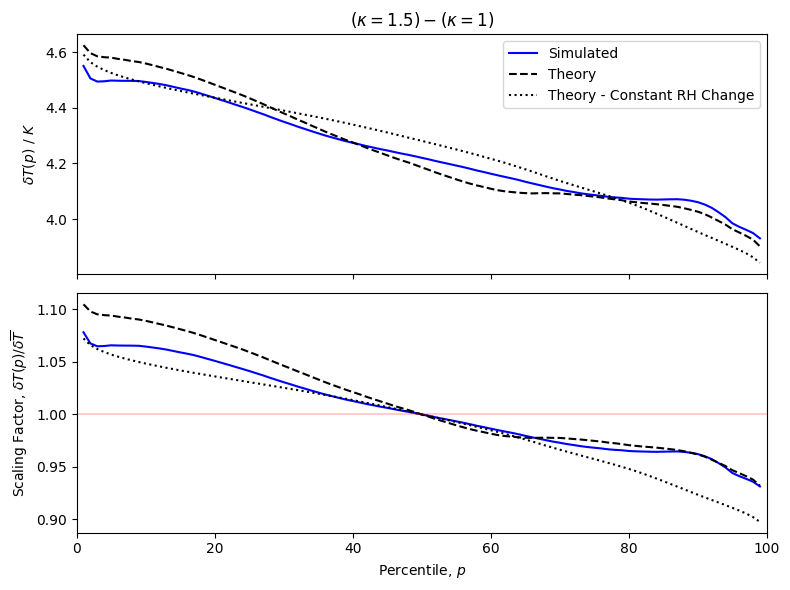

In [133]:
temp_diff_theory_linear2 = gamma_t * delta_temp_mean + gamma_rdiff * (delta_r_mean - delta_r_p)
fig, ax = plt.subplots(2,1, figsize=(8, 6), sharex=True)
ax[0].plot(quant_plot, temp_quant2[1]-temp_quant2[0], label = 'Simulated', color='blue')
ax[0].plot(quant_plot, temp_diff_theory_linear2, color='k', linestyle='--',
           label='Theory')
ax[0].plot(quant_plot, gamma_t * delta_temp_mean, color='k', label='Theory - Constant RH Change', linestyle=':')
ax[1].plot(quant_plot, (temp_quant2[1]-temp_quant2[0])/(temp_quant2[1]-temp_quant2[0])[av_quant_ind],
           label = 'Simulated', color='b')
ax[1].plot(quant_plot, temp_diff_theory_linear2/temp_diff_theory_linear2[av_quant_ind], color='k', linestyle='--')
ax[1].plot(quant_plot, gamma_t * delta_temp_mean/(gamma_t * delta_temp_mean)[av_quant_ind],
           color='k', label='Theory - Constant RH Change', linestyle=':')
ax[1].hlines(1, -10, 100, color='r', alpha=0.2)
ax[0].legend()
ax[1].set_xlabel('Percentile, $p$')
ax[0].set_ylabel('$\delta T(p)$ / $K$')
ax[1].set_ylabel('Scaling Factor, $\delta T(p) / \delta \overline{T}$')
ax[0].set_xlim(0,100)
ax[0].set_title(f'$(\kappa={tau_lw[1]})-(\kappa={tau_lw[0]})$')
plt.tight_layout()

if save_fig:
    fig.savefig(f"/Users/joshduffield/Desktop/temp{str(tau_lw_ref).replace('.','_')}")

## Connect to Free Troposphere
To explain why the theory works in the tropics in terms of a physical mechanism, we link the surface to the free troposphere here.

### Percentile vs average around a percentile
To do this more robustly, rather than just considering a single day for each percentile, we take the average of all days around a given percentile e.g. for $x=90$, we consider average over all days with a temperature percentile between $89.5 < x \leq 90.5$. We do a sanity check below to make sure this doesn't change the temperature and relative humidity terms shown above too much.

In the plots below, $p$ refers to the percentile for that quantity e.g. $h(p)$ is the percentile $p$ of MSE. $x$ refers to the average over all days between $x-0.5$ and $x+0.5$ percentile of a given quantity e.g. $h(x_T=90)$ is the MSE averaged over all days with temperature between the 89.5 and 90.5 percentile.

In [134]:
# Get values averaged around a temperature percentile, rather than exactly on it.
temp_quant3 = np.zeros_like(temp_quant2)
sphum_quant3 = np.zeros_like(sphum_quant2)
mse_quant3 = np.zeros_like(mse_quant2)
temp_quant4 = np.zeros_like(temp_quant2)
sphum_quant4 = np.zeros_like(sphum_quant2)
mse_quant4 = np.zeros_like(mse_quant2)
with tqdm(total=n_exp*n_quant, position=0, leave=True) as pbar:
    for i in range(n_exp):
        for j, quant in enumerate(quant_plot):
            # Take percentile to be temperature percentile
            use_ind = get_quant_ind(ds_all[i], quant, 0.5, 0.5)
            temp_quant3[i, j] = ds_all[i].temp[-1, use_ind].mean()
            sphum_quant3[i, j] = ds_all[i].sphum[-1, use_ind].mean()
            mse_quant3[i, j] = moist_static_energy(ds_all[i].temp[-1, use_ind], ds_all[i].sphum[-1, use_ind],
                                                   ds_all[i].height[-1, use_ind]).mean()
            # Take percentile to be sphum percentile
            use_ind = get_quant_ind(ds_all[i], quant, 0.5, 0.5, ds_all[i].sphum[-1])
            temp_quant4[i, j] = ds_all[i].temp[-1, use_ind].mean()
            sphum_quant4[i, j] = ds_all[i].sphum[-1, use_ind].mean()
            mse_quant4[i, j] = moist_static_energy(ds_all[i].temp[-1, use_ind], ds_all[i].sphum[-1, use_ind],
                                                   ds_all[i].height[-1, use_ind]).mean()
            pbar.update(1)

100%|██████████| 198/198 [00:10<00:00, 18.18it/s]


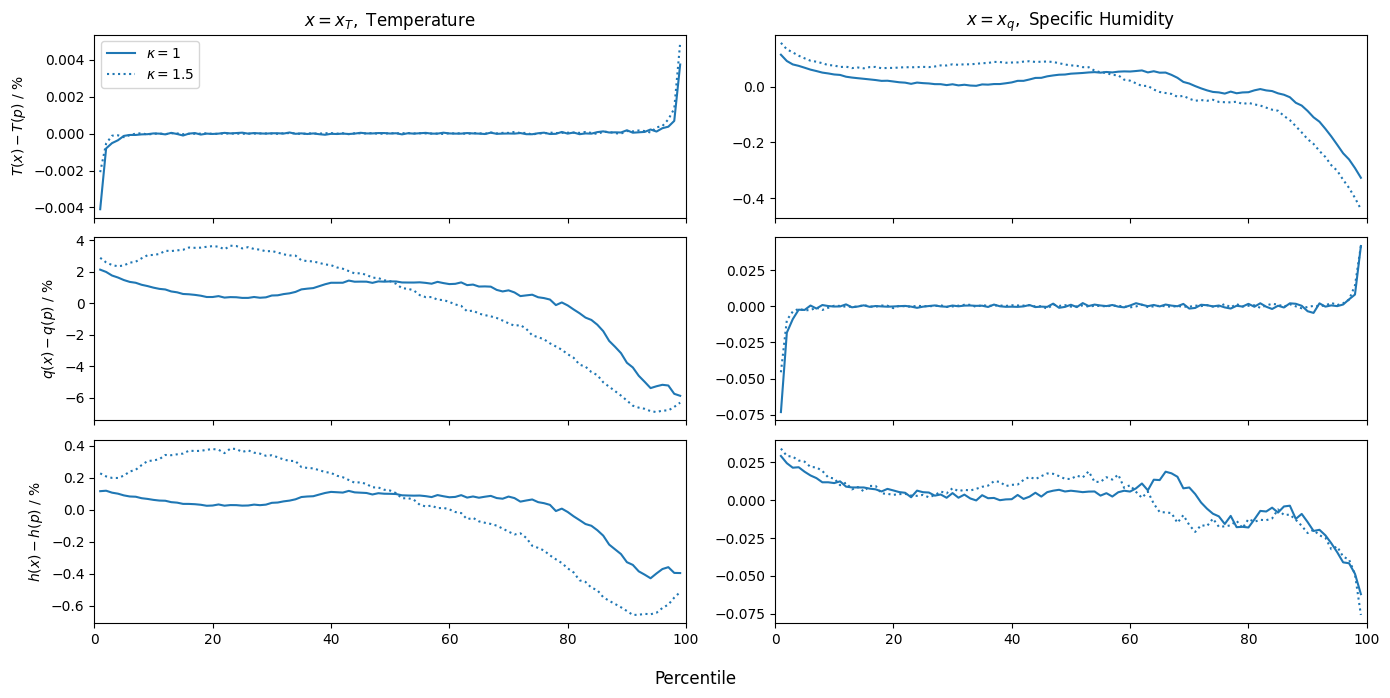

In [157]:
fig, ax = plt.subplots(3,2, figsize=(14, 7), sharex=True)
for i in range(n_exp):
    ax[0, 0].plot(quant_plot, 100 * (temp_quant3[i]-temp_quant2[i])/temp_quant3[i], color=default_colors[0],
               linestyle=linestyles[i], label=f'$\kappa={tau_lw[i]}$')
    ax[1, 0].plot(quant_plot, 100 * (sphum_quant3[i]-sphum_quant2[i])/sphum_quant3[i], color=default_colors[0],
               linestyle=linestyles[i], label=f'$\kappa={tau_lw[i]}$')
    ax[2, 0].plot(quant_plot, 100 * (mse_quant3[i]-mse_quant2[i])/mse_quant3[i], color=default_colors[0],
               linestyle=linestyles[i], label=f'$\kappa={tau_lw[i]}$')
    ax[0, 1].plot(quant_plot, 100 * (temp_quant4[i]-temp_quant2[i])/temp_quant4[i], color=default_colors[0],
               linestyle=linestyles[i], label=f'$\kappa={tau_lw[i]}$')
    ax[1, 1].plot(quant_plot, 100 * (sphum_quant4[i]-sphum_quant2[i])/sphum_quant4[i], color=default_colors[0],
               linestyle=linestyles[i], label=f'$\kappa={tau_lw[i]}$')
    ax[2, 1].plot(quant_plot, 100 * (mse_quant4[i]-mse_quant2[i])/mse_quant4[i], color=default_colors[0],
               linestyle=linestyles[i], label=f'$\kappa={tau_lw[i]}$')
ax[0, 0].legend()
ax[0, 0].set_title('$x=x_T,$ Temperature')
ax[0, 1].set_title('$x=x_q,$ Specific Humidity')
ax[0, 0].set_xlim(0,100)
fig.supxlabel('Percentile')
ax[0, 0].set_ylabel('$T(x) - T(p)$ / %')
ax[1, 0].set_ylabel('$q(x) - q(p)$ / %')
ax[2, 0].set_ylabel('$h(x) - h(p)$ / %')
plt.tight_layout();

From above, we see that $T(x_T) = T(p)$ and $q(x_q) = q(p)$ almost exactly, indicating that the averaging over a range of percentiles gives the same answer as using the percentile itself.

For $x=x_T$, the specific humidity differs quite a lot, and this is reflected in the MSE differing quite a lot as well i.e. the specific humidity percentile and temperature percentile are not equivalent because the relative humidity on the hottest days starts to decrease as shown below.

For $x=x_q$, the temperature of the highest percentile days is less, for the same reason, but the MSE plots are much less different and the difference affects both $\kappa$ values in the same way.

Below I plot three versions of relative humidity.
* In black, is the specific humidity on the specific humidity percentile days divided by the saturated specific humidity on the temperature percentile days. This hybrid version doesn't make sense or reflect into any physically meaningful quantity, but it is the definition that I used in the above theory.
* In blue is the relative humidity averaged over the temperature percentile days, and we see a clear decrease in relative humidity for the hottesst days.
* In orange is the relative humidity averaged over the specific humidity percentile days, and we see a clear increase in relative humidity as $x_q$ increases.

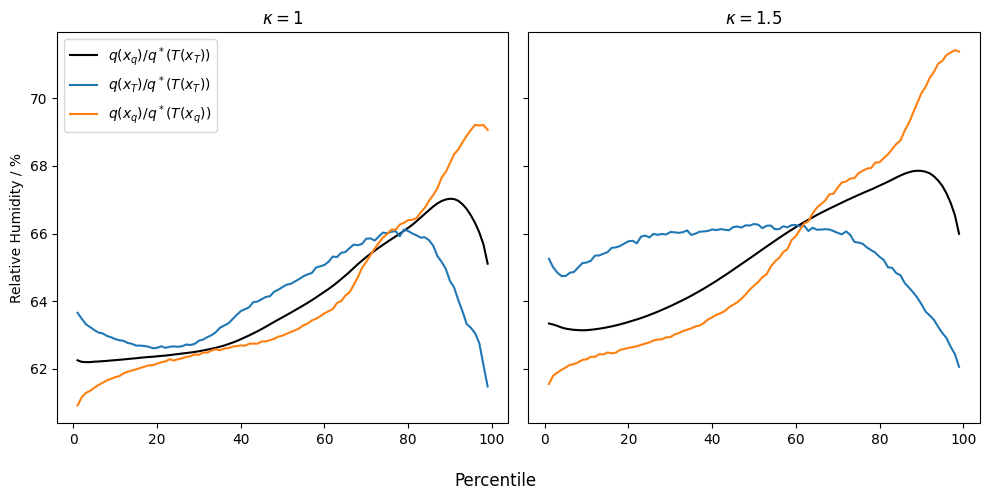

In [163]:
fig, ax = plt.subplots(1,2, figsize=(10, 5), sharex=True, sharey=True)
for i in range(n_exp):
    ax[i].plot(quant_plot, 100*sphum_quant4[i]/sphum_sat(temp_quant3[i], p_surface), color='k',
               label='$q(x_q)/q^*(T(x_T))$')
    ax[i].plot(quant_plot, 100*sphum_quant3[i]/sphum_sat(temp_quant3[i], p_surface), color=default_colors[0],
               label='$q(x_T)/q^*(T(x_T))$')
    ax[i].plot(quant_plot, 100*sphum_quant4[i]/sphum_sat(temp_quant4[i], p_surface), color=default_colors[1],
               label='$q(x_q)/q^*(T(x_q))$')
    ax[i].set_title(f'$\kappa={tau_lw[i]}$')
ax[0].legend()
ax[0].set_ylabel('Relative Humidity / %')
fig.supxlabel('Percentile')
plt.tight_layout();

In the plot below, I show that the MSE change deviates a lot from the actual MSE change if I use the temperature percentile, but almost matches it exactly if I use the specific humidity percentile. This indicates that a theory predicting the temperature change on a given percentile day of specific humidity may be more appropriate.

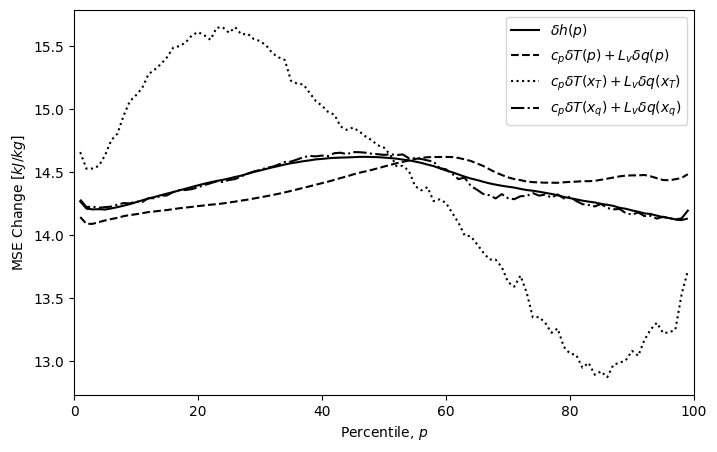

In [162]:
fig = copy.deepcopy(fig_delta_mse)
ax = fig.gca()
ax.plot(quant_plot, (c_p * (temp_quant3[1]-temp_quant3[0]) + L_v * (sphum_quant3[1]-sphum_quant3[0]))/1000,
        label='$c_p \delta T(x_T) + L_v \delta q(x_T)$', color='k', linestyle=':')
ax.plot(quant_plot, (c_p * (temp_quant4[1]-temp_quant4[0]) + L_v * (sphum_quant4[1]-sphum_quant4[0]))/1000,
        label='$c_p \delta T(x_q) + L_v \delta q(x_q)$', color='k', linestyle='-.')
ax.legend()
fig